In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from src.data.dataloader import *
from src.utils.functions import *
from src.utils.plots import *
from src.scripts.graphs import *

## Normalizing the click count

In [11]:
# TODO: document removal of first and last article before counting click counts as well as removing few articles with link count errors
# (some articles like '%C3%85land' or 'Wikipedia_Text_of_the_GNU_Free_Documentation_License' do not have the correct num_links_in !)
articles = pd.read_csv("data/country_clicks_links.csv", index_col=0).reset_index().rename(columns={'index': 'article'})

In [4]:
articles = pd.read_csv("data/country_clicks_links.csv", index_col=0).reset_index().rename(columns={'index': 'article'})
countries_links_in = articles[['Top_1_name', 'num_links_in']].groupby('Top_1_name').agg('sum')
countries_clicks = articles[['Top_1_name', 'click_count']].groupby('Top_1_name').agg('sum')
countries = pd.concat([countries_links_in, countries_clicks], axis=1)
countries['click_count_normalized'] = countries['click_count'] / countries['num_links_in']
countries = countries.reset_index()


#### Visualisation of the click count after normalization

In [5]:
click_count_normalized = countries['click_count_normalized'].tolist()
countries_names = countries_clicks.reset_index().Top_1_name.tolist()

In [6]:
latitudes, longitudes = geolocalization(countries)

Processing countries: 100%|██████████| 195/195 [04:22<00:00,  1.35s/country]


In [ ]:
overlap_world_map_normalized_clicks("normalized_click_counts.html", click_count_normalized, countries_names, latitudes,longitudes)

Map is saved in normalized_click_counts.html!







## 2.3 What articles are most likely to cause a player to stop the game? What makes those articles "dead ends"? What does this have to do with the country of these articles?


Great! There are roads connecting articles that are often clicked consicutively in a same path. Another important question can be raised here: where do these roads end? This is what we will answer in this part.

In [168]:
articles = load_articles_dataframe()
categories = load_categories_dataframe()
finished_paths = load_path_finished_dataframe()
unfinished_paths = load_path_unfinished_distance_dataframe()

In [169]:
df_articles_count = process_article_paths(finished_paths, unfinished_paths, articles)
df_articles_count.head(10)

,article,total_click_count,unique_click_count,unique_success_count,unique_failure_count,success_ratio_total,failure_ratio_total,success_ratio_unique,failure_ratio_unique
0,<,33468,14196,8995,5201,0.268764,0.155402,0.633629,0.366371
1,United_States,12449,12010,8675,3335,0.696843,0.267893,0.722315,0.277685
2,Europe,5611,5497,4303,1194,0.766886,0.212796,0.782791,0.217209
3,United_Kingdom,5328,5161,3807,1354,0.714527,0.254129,0.737648,0.262352
4,England,4558,4429,3261,1168,0.715445,0.256253,0.736284,0.263716
5,Earth,4216,4144,3176,968,0.753321,0.229602,0.766409,0.233591
6,Africa,3590,3499,2738,761,0.762674,0.211978,0.782509,0.217491
7,World_War_II,2931,2876,2267,609,0.773456,0.207779,0.788248,0.211752
8,North_America,2594,2554,1861,693,0.717425,0.267155,0.728661,0.271339
9,Animal,2471,2373,1666,707,0.674221,0.286119,0.702065,0.297935


c:\Users\brygo\Documents\ada-2024-project-lesfraisestagada\src\utils\plots.py:191: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


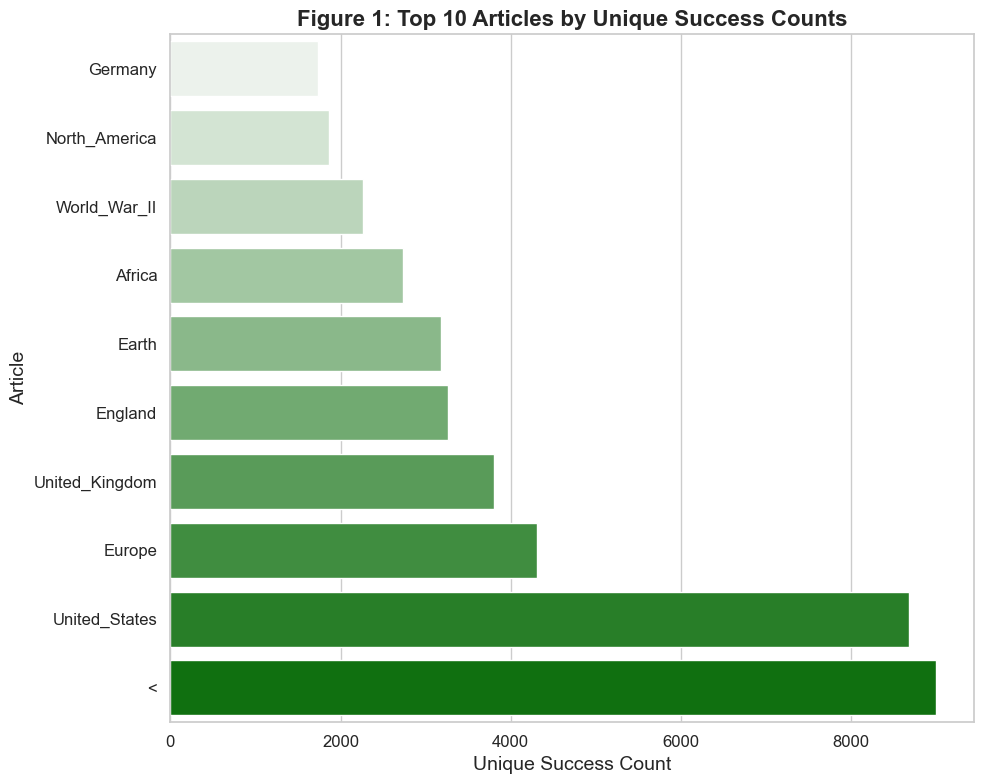

c:\Users\brygo\Documents\ada-2024-project-lesfraisestagada\src\utils\plots.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


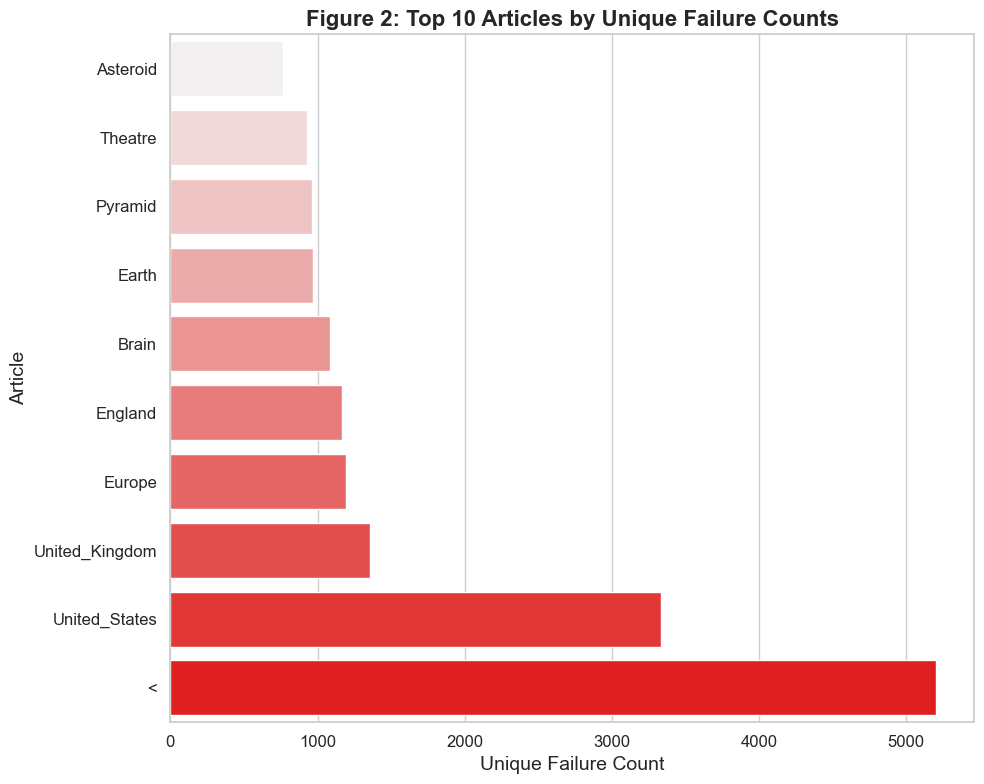

In [172]:
plot_top_k_unique_failure_success_counts(df_articles_count)

In [173]:
go_back_fail_count_u = df_articles_count.loc[df_articles_count['article'] == '<']['unique_failure_count'].values[0]
go_back_success_count_u = df_articles_count.loc[df_articles_count['article'] == '<']['unique_success_count'].values[0]
success_ratio_unique = go_back_success_count_u / (go_back_success_count_u + go_back_fail_count_u)
print(f'The go back button makes on average the player succeed {success_ratio_unique*100:.2f}% of the time')

The go back button makes on average the player succeed 63.36% of the time


This plot gives us a good insight about which articles make users fail/succeed in the Wikispeedia game :

**High success counts in historical/geographical articles** : <br/>
Articles `World_War_II`, `Africa`, and `Germany` appear in the success plot but not in the failure plot. This could indicate that these articles are part of well-connected paths (which we call highway paths) that users are more likely to complete, possibly because they relate to broader, interconnected topics.

**High success rate for the "go back" button** : <br/> 
The "<" button, which allows users to navigate back to a previous article, has a unique success count that is notably higher than its unique failure count, with a success rate of 63.36%. This means that when users go back, they end up completing their path about 63% of the time. The frequent use of the "go back" button suggests that users may often reach pages where they feel unsure of the next step or encounter content that does not meet their expectations, prompting them to backtrack.

While many users successfully navigate onward after going back, a substantial portion still abandons their path after backtracking. This frequent use of the "go back" button, especially before abandonment, implies that certain pages might be acting as dead ends or lacking clear onward navigation.

**High failure counts in specific articles** : <br/>
Certain articles like `Asteroid`, `Theatre`, and `Pyramid` appear only in the failure plot. These may represent topics that are less connected to other parts of the article network, potentially leading users to dead ends. Users reaching these pages may struggle to find relevant onward links, leading to abandonment. Unlike the historical and geographical articles that are well integrated into broader themes, these topics may lack sufficient links to related articles, making it difficult for users to continue their path without backtracking or giving up.

**Top articles with both high success and failure counts** : <br/>
Articles like `United_States`, `United_Kingdom`, and `Europe`, which appear very frequently in our analysis, have high counts in both success and failure plots. This suggests that these articles are pivotal points in the game where users frequently make navigation decisions. While these articles are often part of successful paths, they also lead to user abandons, possibly because of the wide range of potential links that may either facilitate continuation or create confusion.

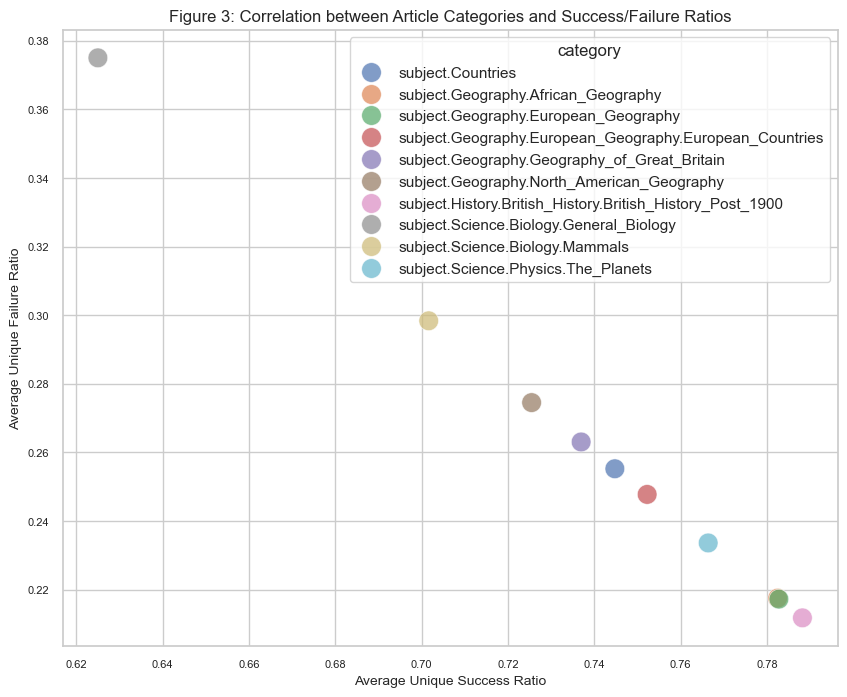

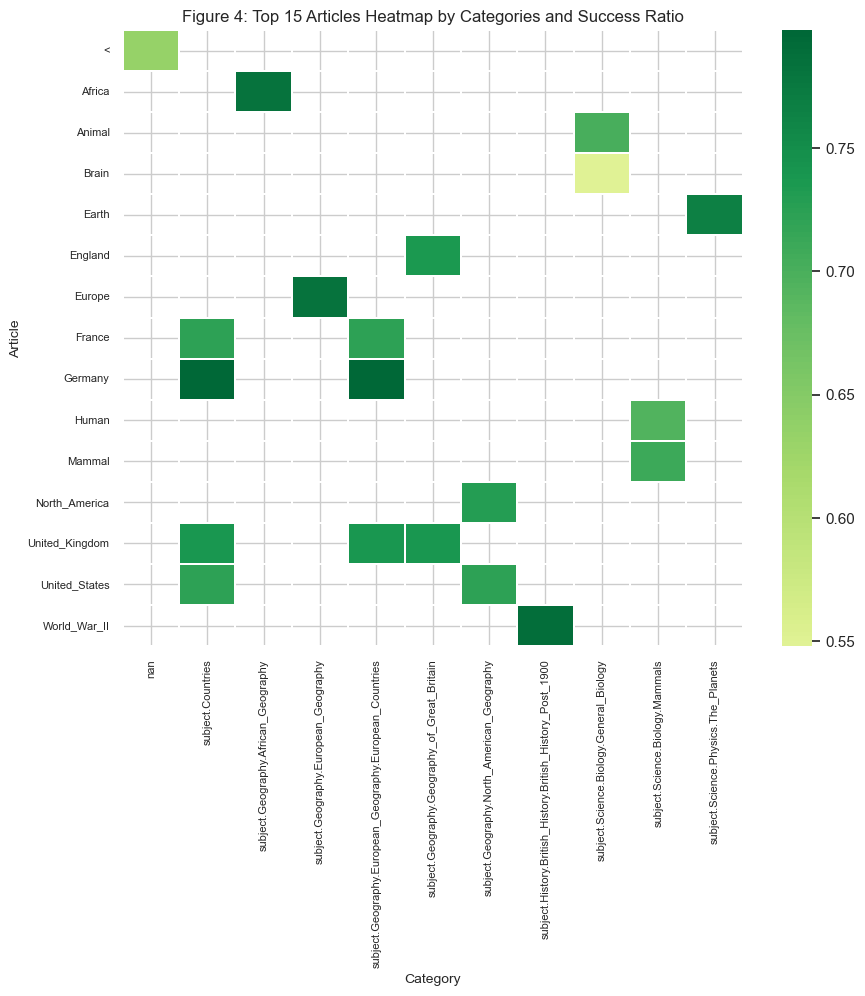

In [174]:
analyze_top_articles_by_category(df_articles_count, categories, top_n=15)

We obverse several things on the above two plots : <br/>

**Geography-related categories** : <br/>
Geography-related categories, such as `European_Geography`, `North_American_Geography`, and `African_Geography`, have high success ratios, suggesting that geographical articles are part of well-connected paths that users complete more frequently.

**Science and biology topics** : <br/>
Categories like `Mammals`, `General_Biology` show moderate success ratios, indicating that these topics might be somewhat connected but don’t facilitate completion as effectively as geography-related paths. Surprisingly, `Physics` (more particularly, The Planets), shows a very high success ratio, suggesting that users may find it easier to follow through on paths involving specific physics topics, possibly due to greater prior knowledge or more structured/linear article content.

**High success with certain historical articles** : <br/>
Historical topics, specifically `British_History_Post_1900`, have a lower failure ratio, suggesting users tend to follow through on these articles more consistently, potentially because of potentially higher knowledge on the subject or clearer onward paths.

**Heatmap distribution** : <br/> 
The heatmap emphasizes the fact that articles in the Countries and general geography categories (`European_Geography`, `Geography_of_Great_Britain`) are strongly associated with higher success ratios, reinforcing the importance of geographical hubs in successful navigation paths.
However an article like the `Brain` has a much lower success ratio, possibly due to players' lack of knowledge on this topic or the lack/complexity of outgoing links.

### What articles are most likely to cause a player to stop the game? 

In [175]:
df_country_clicks_links = pd.read_csv('data/country_clicks_links.csv', index_col=0)

In [176]:
# 1
# select top articles based on failure ratios and unique failure counts
top_dead_end_articles = df_articles_count.sort_values(by=['failure_ratio_unique', 'total_click_count'], ascending=False)
print("Top Dead-End Articles (Most Likely to Cause Players to Stop):")
top_dead_end_articles[['article', 'total_click_count', 'failure_ratio_unique', 'unique_failure_count']].head(10)

Top Dead-End Articles (Most Likely to Cause Players to Stop):


,article,total_click_count,failure_ratio_unique,unique_failure_count
4039,Hurricane_Gloria,4,1.0,4
4043,Hilda_of_Whitby,4,1.0,4
4078,Malwa_%28Madhya_Pradesh%29,4,1.0,4
4090,Eliminative_materialism,3,1.0,3
4105,San_Diego_and_Arizona_Railway,3,1.0,3
4111,Lynton_and_Barnstaple_Railway,2,1.0,2
4127,Battle_of_Smolensk_%281943%29,2,1.0,2
4129,Richard_O%27Connor,2,1.0,2
4150,Private_Peaceful,1,1.0,1
4156,Nadia_Com%C4%83neci,1,1.0,1


### What makes those articles "dead ends"?

In [177]:
# prepare for merge
df_country_click_links_reset = df_country_clicks_links.reset_index().rename(columns={'index': 'article'})

# merge to get the country
dead_end_countries = pd.merge(
    df_country_click_links_reset, 
    top_dead_end_articles, 
    on='article', 
    how='inner'
)

print("Top Dead-End Articles (Most Likely to Cause Players to Stop) related to link counts:")
dead_end_countries.sort_values(by=['failure_ratio_unique','total_click_count'], ascending=False)[['article', 'num_links_in', 'num_links_out', 'failure_ratio_unique']].head(10)


Top Dead-End Articles (Most Likely to Cause Players to Stop) related to link counts:


,article,num_links_in,num_links_out,failure_ratio_unique
1925,Hilda_of_Whitby,2.0,16.0,1.0
2048,Hurricane_Gloria,2.0,6.0,1.0
2621,Malwa_%28Madhya_Pradesh%29,3.0,29.0,1.0
1353,Eliminative_materialism,1.0,12.0,1.0
3616,San_Diego_and_Arizona_Railway,2.0,8.0,1.0
504,Battle_of_Smolensk_%281943%29,2.0,13.0,1.0
2574,Lynton_and_Barnstaple_Railway,3.0,11.0,1.0
3490,Richard_O%27Connor,1.0,35.0,1.0
313,Architecture_of_Windows_NT,NaN,3.0,1.0
844,CF7,2.0,6.0,1.0


These dead-end articles each have a 100% failure ratio, meaning players abandon their path every time they reach one of these pages. Many of these articles are highly specific, niche topics tied to particular historical or cultural contexts, such as `Hurricane Gloria` in the United States, `Hilda of Whitby` in early Christian England, and `Nadia Comăneci` from Romania. Despite having some incoming links, most of these pages offer limited outgoing links (such as `Architecture of Windows NT` with only 3 outgoing links), restricting the options for onward navigation. This lack of connectivity to other commonly traversed topics creates a navigational dead end, making it difficult for players to find relevant paths to continue, effectively leading to abandonment in the Wikispeedia game.

###  What does this have to do with the country of these articles?

We'd like to have unique countries in the dataframe to get a clear view of each country's overall impact as a dead-end article without redundancy.
It's important to avoid duplicate entries, which would skew metrics like total click counts and success/failure ratios. 

The following approach creates a single, summarized entry for each country, preserving meaningful metrics and avoiding arbitrary duplicate drops. It allows for a comprehensive view of each country’s overall engagement and dead-end behavior within the dataset.

In [178]:
# group by 'Top_1_name' (country) and aggregate the data
unique_dead_end_countries = (
    dead_end_countries
    .groupby('Top_1_name', as_index=False)
    .agg({
        'click_count': 'sum',             # Sum click counts to get total clicks per country
        'num_links_out': lambda x: int(round(x.sum())),          # Sum of outgoing links
        'num_links_in': lambda x: int(round(x.sum())),           # Sum of incoming links
        'unique_success_count': 'sum',    # Sum of unique success counts per country
        'unique_failure_count': 'sum',    # Sum of unique failure counts per country
        'success_ratio_total': 'mean',    # Mean of total success ratios
        'failure_ratio_total': 'mean',    # Mean of total failure ratios
        'success_ratio_unique': 'mean',   # Mean of unique success ratios
        'failure_ratio_unique': 'mean'    # Mean of unique failure ratios
    }).rename(columns={
        'num_links_out': 'sum_num_links_out',
        'num_links_in': 'sum_num_links_in',
        'success_ratio_total': 'mean_success_ratio_total',
        'failure_ratio_total': 'mean_failure_ratio_total',
        'success_ratio_unique': 'mean_success_ratio_unique',
        'failure_ratio_unique': 'mean_failure_ratio_unique'
    })
)

unique_dead_end_countries = unique_dead_end_countries.sort_values(by=['click_count'], ascending=False)

unique_dead_end_countries.head(10)

,Top_1_name,click_count,sum_num_links_out,sum_num_links_in,unique_success_count,unique_failure_count,mean_success_ratio_total,mean_failure_ratio_total,mean_success_ratio_unique,mean_failure_ratio_unique
185,united states,36078,11710,9562,34993,13220,0.604929,0.248900,0.609996,0.251265
184,united kingdom,17150,6453,6315,16252,5614,0.645435,0.249759,0.649921,0.251556
64,germany,9244,3284,3750,9448,3026,0.706367,0.220213,0.711659,0.222303
59,france,8476,3487,4487,7933,2912,0.670494,0.247028,0.676006,0.249227
87,italy,8288,2530,3152,7700,2928,0.657015,0.239025,0.661918,0.240995
39,china,6158,2454,2696,6449,2120,0.724648,0.222597,0.728767,0.224174
161,south africa,5815,1236,1261,5464,1418,0.730293,0.185385,0.734290,0.186762
10,australia,5814,2534,2241,5969,2102,0.638846,0.225703,0.643508,0.228051
67,greece,5599,1672,1732,5274,1892,0.675084,0.224611,0.683117,0.227597
80,india,5462,2767,2425,5535,1960,0.686685,0.228490,0.692581,0.230496


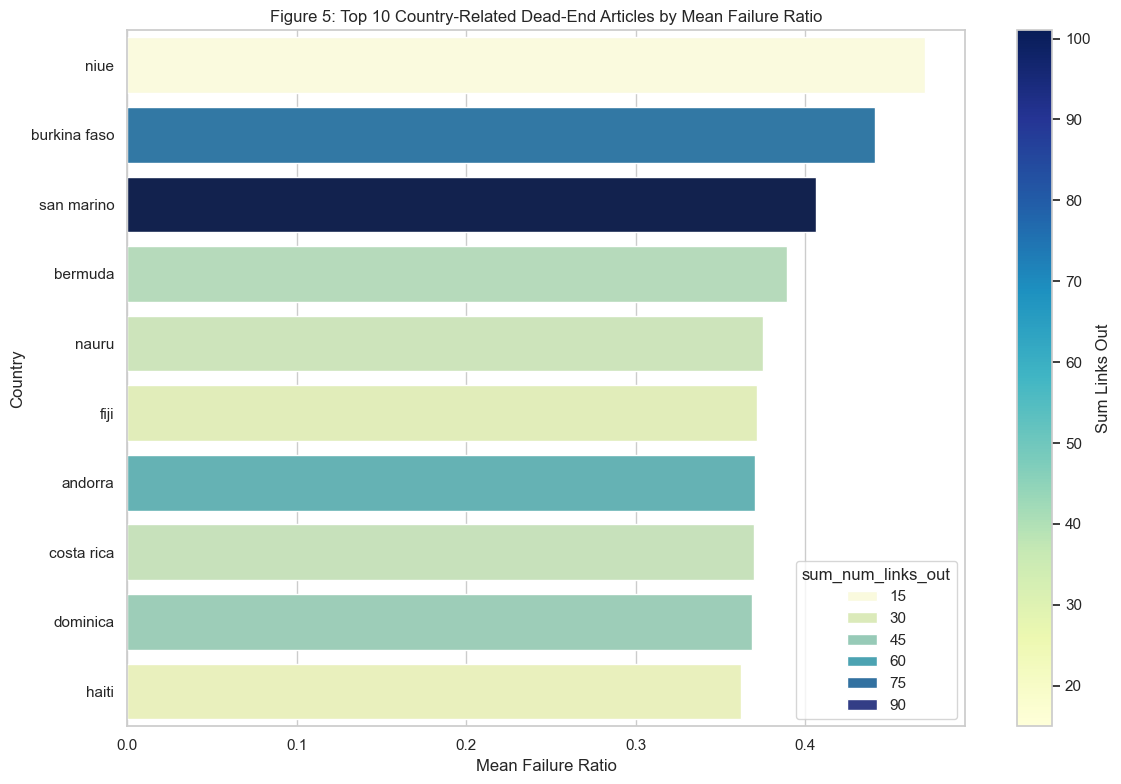

In [179]:
plot_top_dead_end_countries(unique_dead_end_countries, i=5)

### What if we take into account the click counts?

These countries have a very low click count, what if we take into account the number of clicks ? 

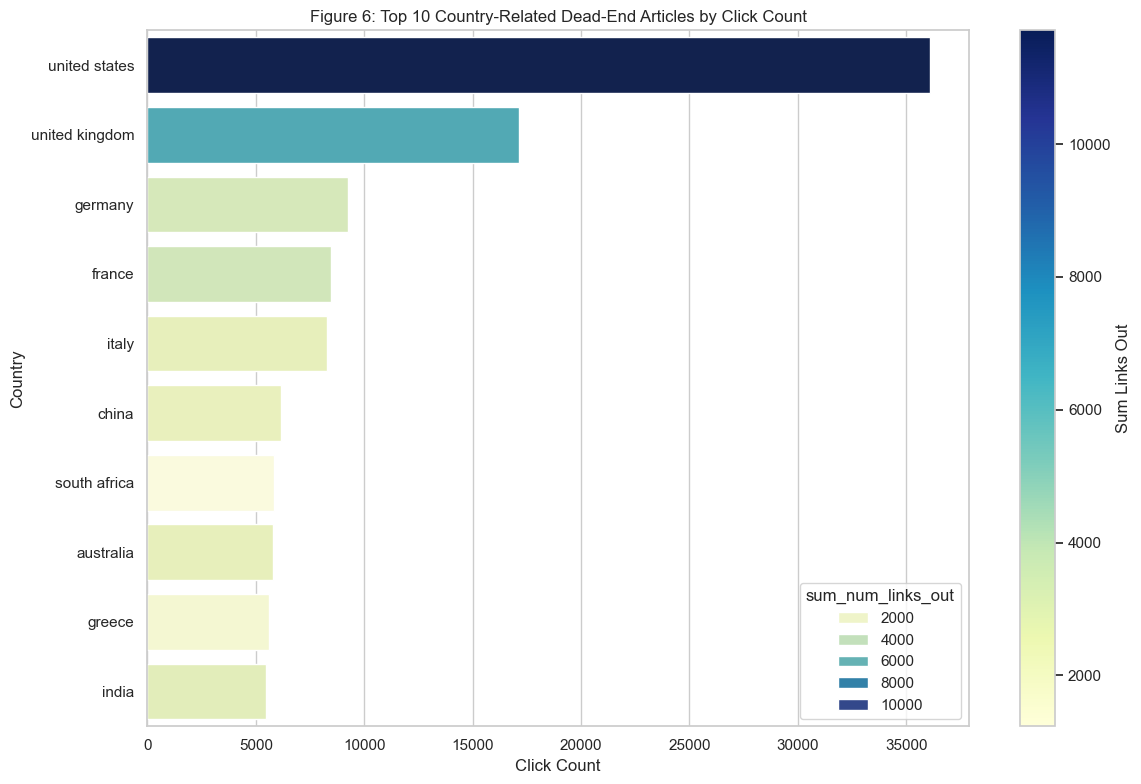

In [180]:
plot_top_dead_end_countries(unique_dead_end_countries, use_click_count=True, i=6)

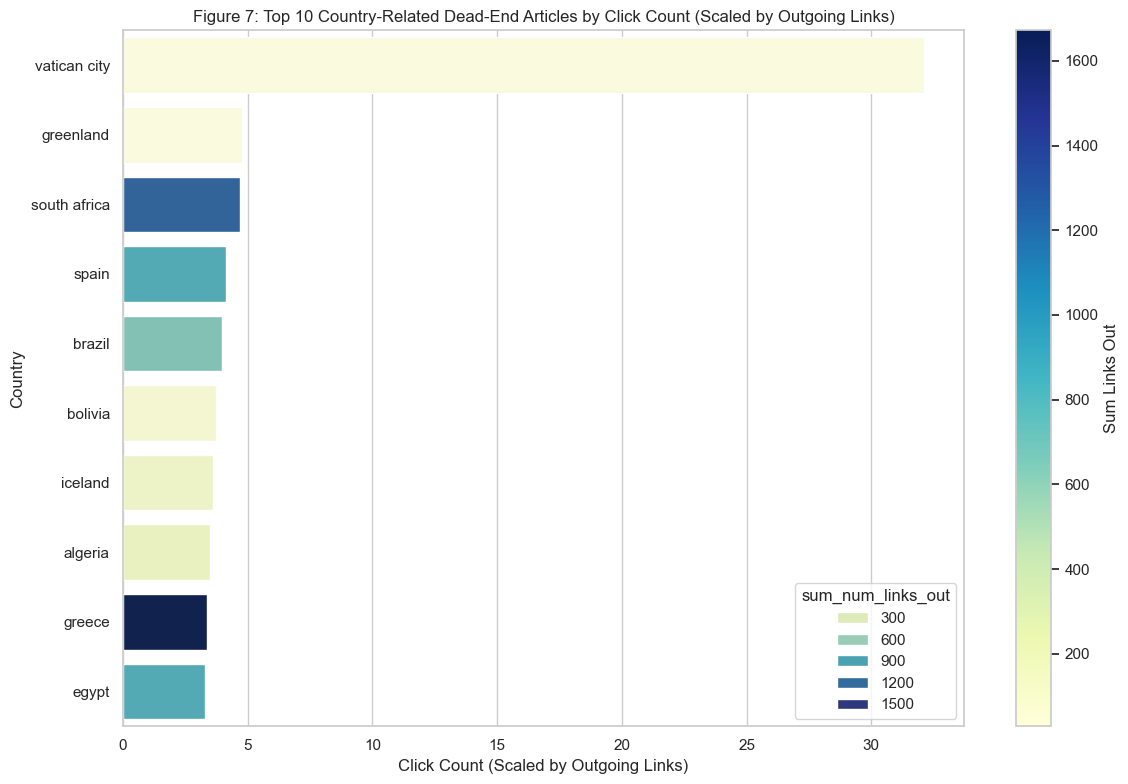

In [181]:
# Scale the click count by the mean number of outgoing links
unique_dead_end_countries["scaled_click_count"] = unique_dead_end_countries["click_count"] / unique_dead_end_countries["sum_num_links_out"]

# Plot using the updated DataFrame with scaled click count
plot_top_dead_end_countries(unique_dead_end_countries, use_click_count=True, use_scaled=True, i=7)


### Let's analyse the last article's country of unfinished paths(how many times does it appear? is it a dead end ?)

c:\Users\brygo\Documents\ada-2024-project-lesfraisestagada\src\utils\plots.py:344: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


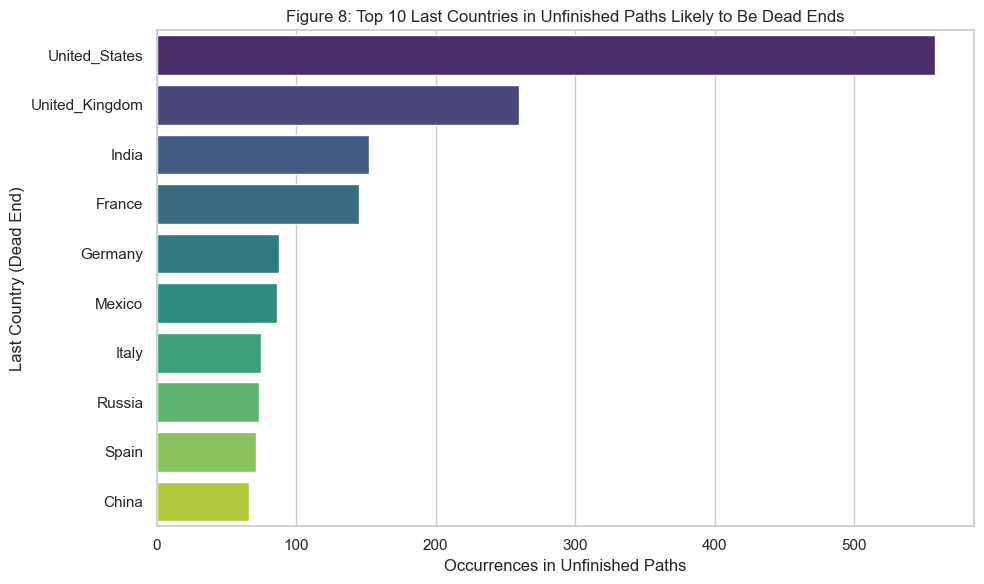

In [182]:
last_dead_end_countries = analyze_last_articles_in_unfinished_paths(unfinished_paths, unique_dead_end_countries)
plot_top_last_dead_end_countries(last_dead_end_countries, i=8)

### scaled by the number of links out

c:\Users\brygo\Documents\ada-2024-project-lesfraisestagada\src\utils\plots.py:344: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


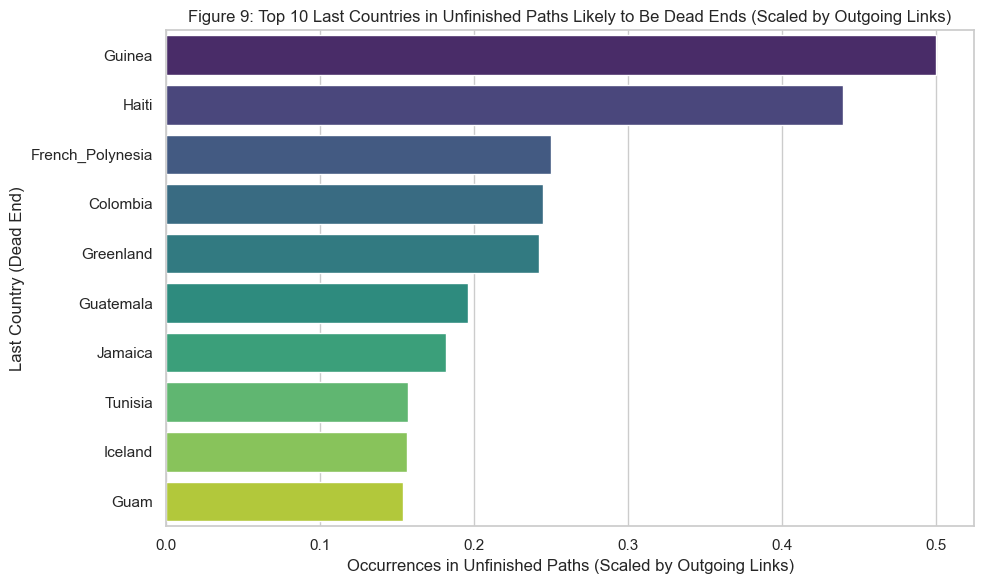

In [183]:
# calculate scaled values for plotting
last_dead_end_countries['scaled_count'] = last_dead_end_countries['count'] / last_dead_end_countries['sum_num_links_out']
plot_top_last_dead_end_countries(last_dead_end_countries, use_scaled=True, i=9)

### Pushing it further : 
#### Get the count of all articles that come before the "<" and link it with the failure ratio

c:\Users\brygo\Documents\ada-2024-project-lesfraisestagada\src\utils\plots.py:384: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


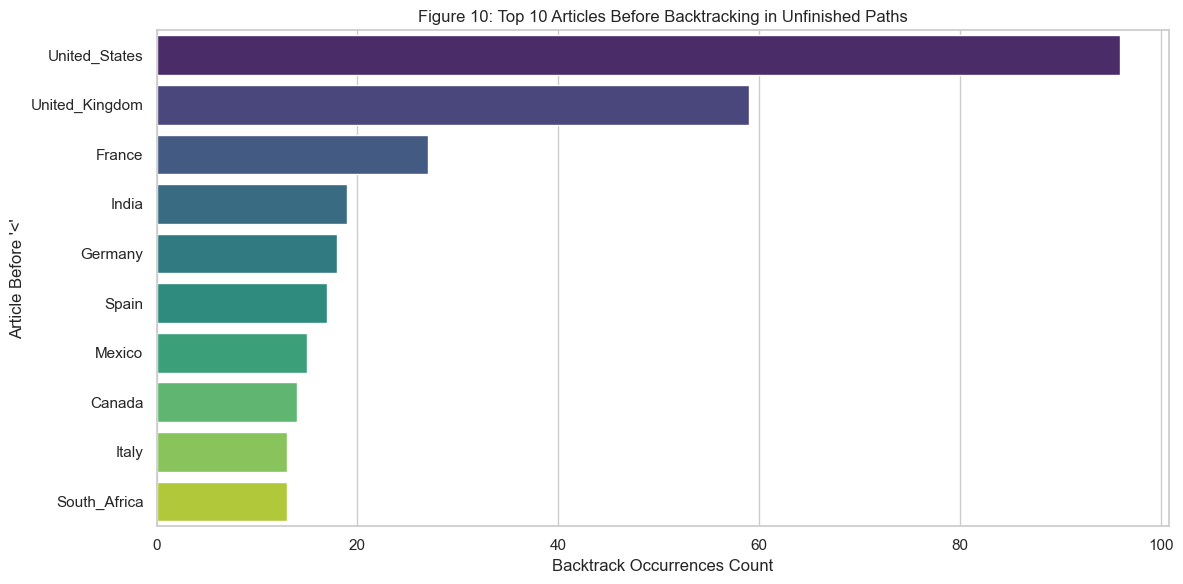

In [184]:
articles_before_go_back_sorted = get_articles_before_go_back(unfinished_paths, unique_dead_end_countries)
plot_articles_before_go_back(articles_before_go_back_sorted, i=10)

c:\Users\brygo\Documents\ada-2024-project-lesfraisestagada\src\utils\plots.py:384: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


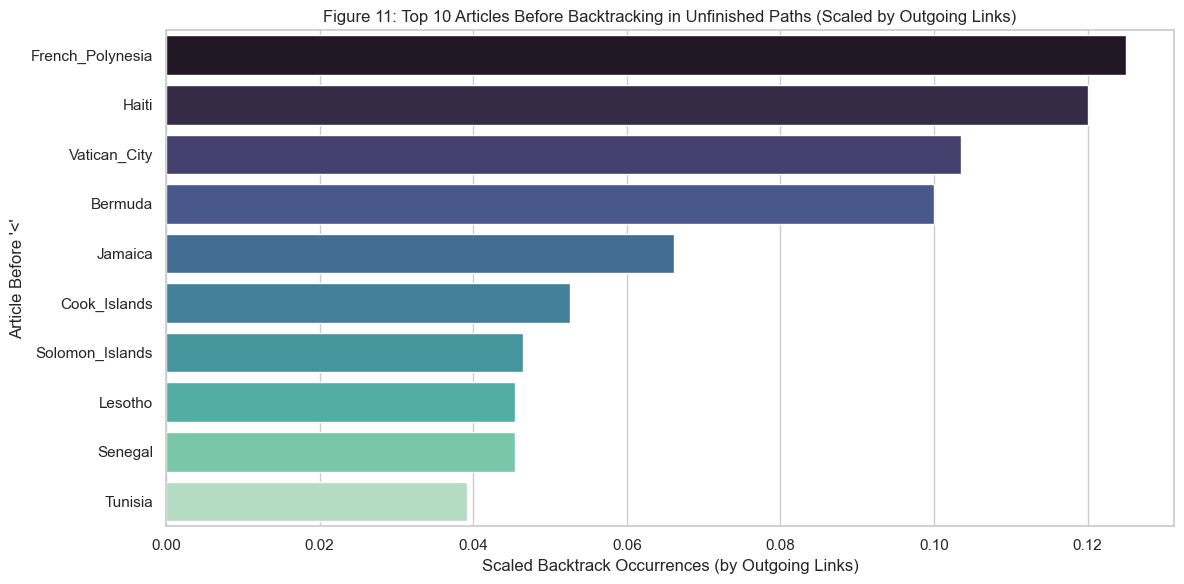

In [185]:
plot_articles_before_go_back(articles_before_go_back_sorted, use_scaled=True, i=11)

# 3. How can we explain the players' biases?

Now that we have finished a naive analysis of the player's biases in the Wikispeedia game, let's further investigate the intrinsic biases of the Wikipedia graph. 


## 3.1 What is the distribution of countries among start / target articles for the Wikispeedia games? If it is not balanced, could this be an explanation?

### Analysis of the countries relations between the start and the end of finished paths.

In [186]:
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
country_clicks["name_links_out"] = country_clicks["name_links_out"].fillna("[]")
country_clicks["num_links_in"] = country_clicks["num_links_in"].fillna(0)
country_clicks["num_links_out"] = country_clicks["num_links_out"].fillna(0)
country_clicks["name_links_out"] = country_clicks["name_links_out"].apply(literal_eval)

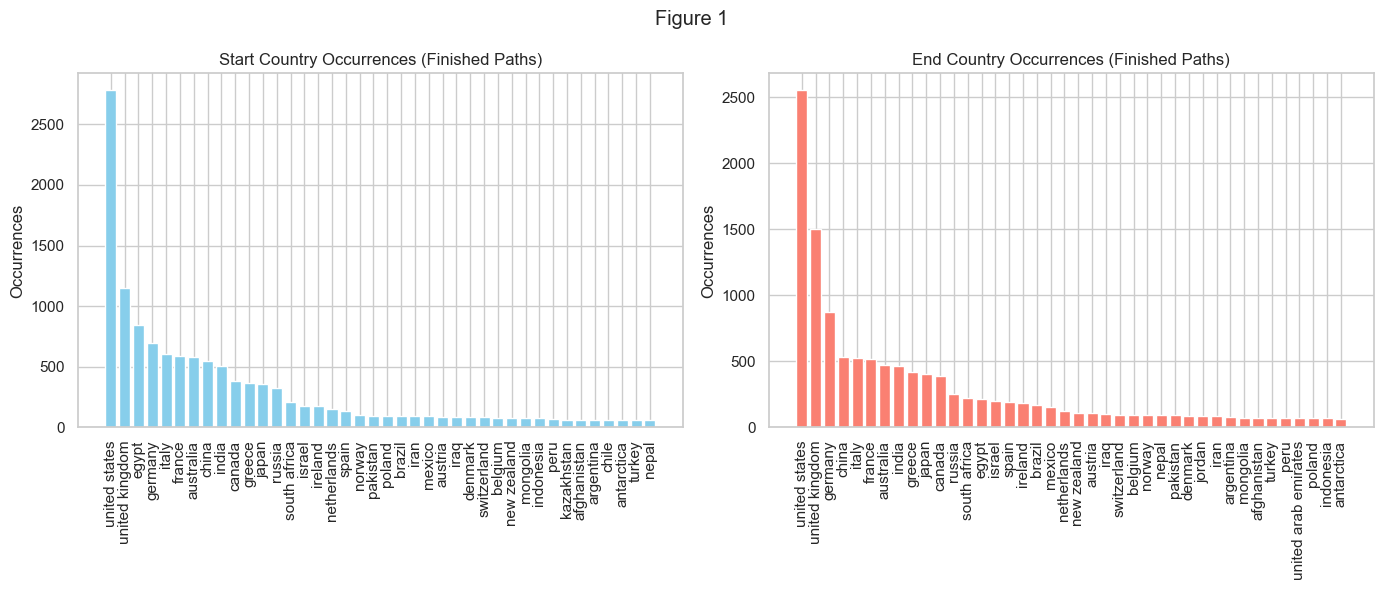

In [187]:
finished_paths = load_path_finished_dataframe()
unfinished_paths = load_path_unfinished_distance_dataframe()

finished_paths["path"] = finished_paths["path"].str.split(";")
unfinished_paths["path"] = unfinished_paths["path"].str.split(";")

paths_to_country(finished_paths, country_clicks, fig_num="1", finished=True)
    

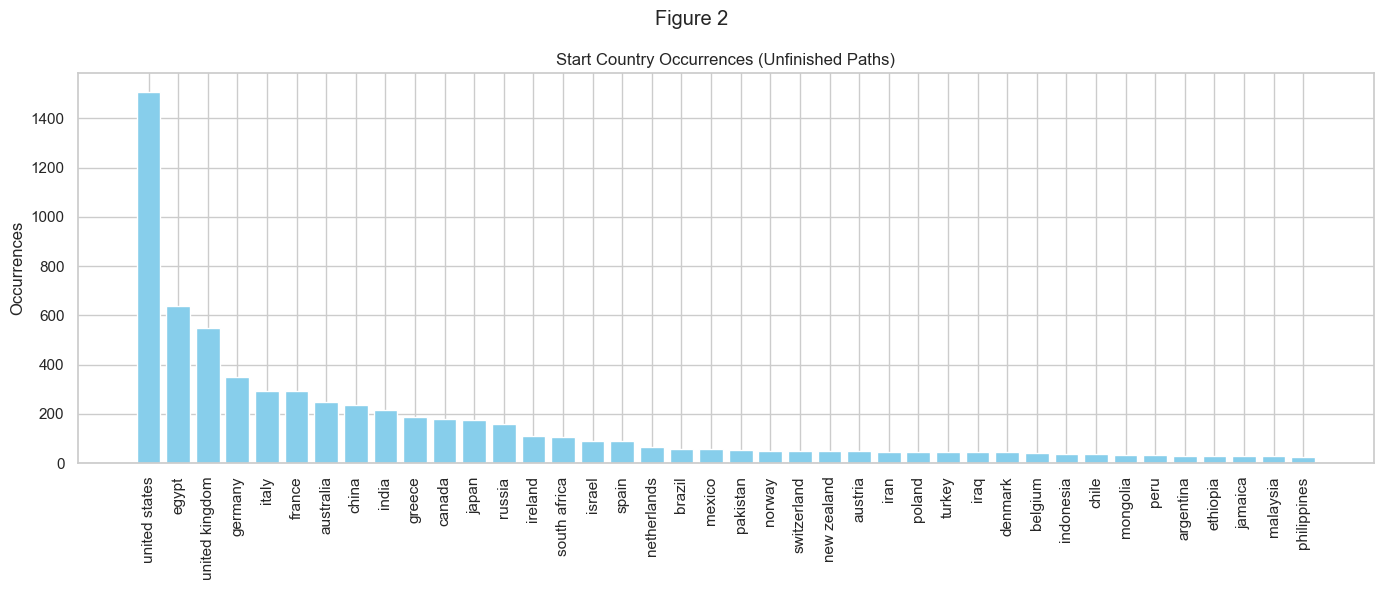

In [188]:
paths_to_country(unfinished_paths, country_clicks, fig_num="2", finished=False)


We see that for finished or unfinished path the trend is that articles related to the United States are mostly "selected" as start articles for players. This implies that it counts as a click in the clicks_count statistics and implicitely creates a bias towards some countires even before the game has started. This can be explained by the fact that  start and end articles for a game are randomly selected which implies that that they will overrepresent the countries having more articles and underrepresent articles related to countries with few articles.

An ideal game for our experimental setup would be to have the same number of chances to have an article from the USA's as start than an article from every other country.

## 3.2 Can we explain the variance in player's click counts with the number of links leading in and out of article?

The first approach is based on the fact that we observed that a lot of articles are classified into 2 predominant countries categories. We thus thought that the country category could have an impact on the number of clicks an article is getting. 
We used an ordinary least squares solver in order to describe this data and tried to predict : 
```click_count ~ num_links_in + num_links_out + C(Top_1_name)```
The number of incoming/outgoing links can also be seen as a useful feature in order to predict the number of clicks an article recieves so this is why there are also included. 
In this case neither num_links_in, num_links_out or click_count were normalized since it is more intuitive to have coefficients in terms of clicks than in term of probabilities. In case the outputs need to be normalized, uncomment the following lines

In [189]:
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
country_clicks["log_click_count"] = np.log(country_clicks["click_count"] + 1)
country_clicks["log_num_links_in"] = np.log(country_clicks["num_links_in"] + 1)
country_clicks["log_num_links_out"] = np.log(country_clicks["num_links_out"] + 1)
# country_clicks["click_count"] = country_clicks["click_count"] / country_clicks["click_count"].sum()
# country_clicks["num_links_in"] = (country_clicks["num_links_in"] - country_clicks["num_links_in"].mean()) / country_clicks["num_links_in"].std()
# country_clicks["num_links_out"] = (country_clicks["num_links_out"] - country_clicks["num_links_out"].mean()) / country_clicks["num_links_out"].std()

In [191]:
mod = smf.ols(formula='click_count ~ num_links_in + num_links_out + C(Top_1_name)', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     23.05
Date:              ven., 13 déc. 2024   Prob (F-statistic):               0.00
Time:                        23:48:55   Log-Likelihood:                -15266.
No. Observations:                2287   AIC:                         3.093e+04
Df Residuals:                    2090   BIC:                         3.206e+04
Df Model:                         196                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

By analysing the coefficients we see that all p-values of country categories are larger than the alpha-level of 5% (except for antartica for which p-value = 0.003 < 0.05), so we can reject the hypothesis that the countries have a meaningful impact on the number of clicks an article recieves at a significant level. ```Antarctica``` was found to be a significant variable to estimate the number of clicks that an article might get. The coefficient of this variable is 248, meaning that according to the regression, if an article is related to the country of Antarctica, it has 248 times for changes to be clicks. This is very suprising! And might arise from the fact that articles such are 'Earth' (which has a huge amount of clicks: 4216), are associated to Antarctica. Those articles might drive the association between the click count and the variable Antarctica!

Note: The [2] warning tells us that we have a problem of multicollinearity which means that multiple of our independent variables are likely correlated. This can induce misleading conclusions. Below we go to a simpler model resolving this problem. We also have a very stron AIC value wich is due to the fact that we have many parameters in our model (all countries + num_links_in + num_links_out)

Given the results another variable we can't reject at a significant level of 5% is the ```num_links_in``` (p-value = 0 because so small that it is approximated by 0). We will thus further analyse this with a simpler model :  
```click_count ~ num_links_in```

In [192]:
mod = smf.ols(formula='click_count ~ num_links_in', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     7575.
Date:              ven., 13 déc. 2024   Prob (F-statistic):               0.00
Time:                        23:49:13   Log-Likelihood:                -27459.
No. Observations:                4135   AIC:                         5.492e+04
Df Residuals:                    4133   BIC:                         5.493e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -34.7475      3.151    -11.029   

Doing the regression of the log of the click counts (reflex to model the log instead of the raw data since the click count ressembles a power law) using the log of the number of links into the article significantly improves the model! Indeed, the AIC is hugely lowered and the R-squared is stable!

```log_click_count ~ log_num_links_in```

In [193]:
mod = smf.ols(formula='log_click_count ~ log_num_links_in', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        log_click_count   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     9221.
Date:              ven., 13 déc. 2024   Prob (F-statistic):               0.00
Time:                        23:49:16   Log-Likelihood:                -5875.8
No. Observations:                4135   AIC:                         1.176e+04
Df Residuals:                    4133   BIC:                         1.177e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3728      0.035  

In both above cases it can be seen that the both the intercept and the num_links_in coefficients are significant at the 5%-level and are thus significant in order to predict the number of clicks an articles recieves. This means that the number of incoming links is related to the number of clicks an article has and moreover each incoming link increases the chance of an article to be clicked by nearly 4, for the non-log-transformed model, and by 0.78 for the log-transformed model. 

For completeness we will look at another simple model :  
```click_count ~ log_num_links_out```

In [194]:
mod = smf.ols(formula='click_count ~ log_num_links_out', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     367.6
Date:              ven., 13 déc. 2024   Prob (F-statistic):           7.11e-79
Time:                        23:49:18   Log-Likelihood:                -32421.
No. Observations:                4583   AIC:                         6.485e+04
Df Residuals:                    4581   BIC:                         6.486e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -248.0272     17.05

We will provide a last analysis trying to see if the number of outgoing links are significant to the number of clicks an article recieves (everything in log-scale of course!). 
The formula used for this is : ```log_click_count ~ log_num_links_in * log_num_links_out``` so that the cross term is also present.

In [195]:
mod = smf.ols(formula='log_click_count ~ log_num_links_in * log_num_links_out', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        log_click_count   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     3067.
Date:              ven., 13 déc. 2024   Prob (F-statistic):               0.00
Time:                        23:49:19   Log-Likelihood:                -5867.0
No. Observations:                4129   AIC:                         1.174e+04
Df Residuals:                    4125   BIC:                         1.177e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

It could be that certain articles are clicked more often simply because they contain more links and this information might be intuitively known by the players of the Wikispeedia game which could explain way they tend to click on those "link hub" articles. It could also be that the articles that are most clicked are those that are most cited in other articles. This would mean that players have higher chances to encounter those articles which could explain the higher click count. 

To investigate those 2 hypotheses, we will look at the correlations between the number of clicks and the number of links in and out of articles. 

In [196]:
country_clicks[['num_links_in', 'num_links_out','click_count', 'log_click_count', 'log_num_links_in']].corr(method="spearman")

,num_links_in,num_links_out,click_count,log_click_count,log_num_links_in
num_links_in,1.000000,0.587972,0.817726,0.817726,1.000000
num_links_out,0.587972,1.000000,0.505311,0.505311,0.587972
click_count,0.817726,0.505311,1.000000,1.000000,0.817726
log_click_count,0.817726,0.505311,1.000000,1.000000,0.817726
log_num_links_in,1.000000,0.587972,0.817726,0.817726,1.000000


To have a visual representation of the relationships between the clicks and the number of links in and out for each article we plot below three scatter plots. On top of each plot we display the regression line found by the above OLS regressions.

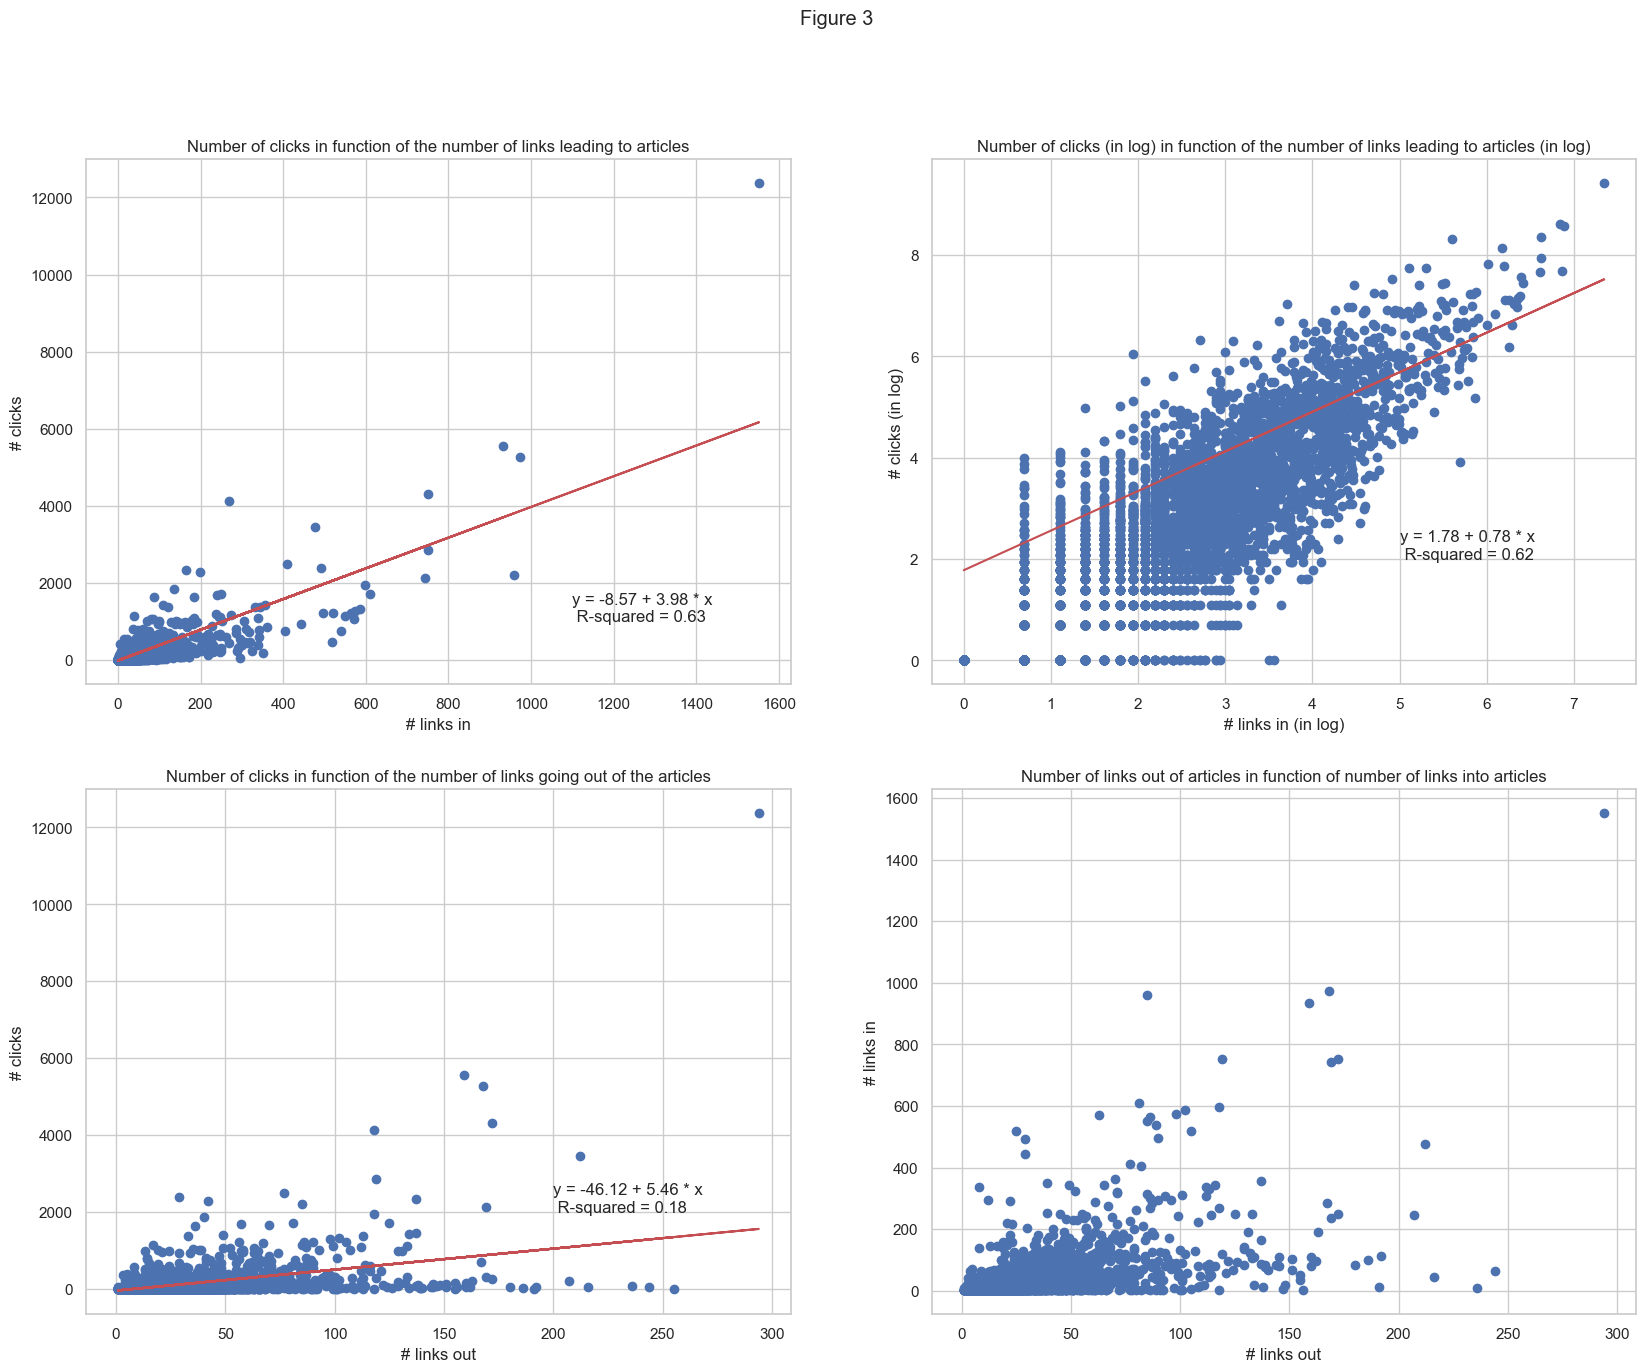

In [197]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

plot_regression_clicks_links(x=country_clicks['num_links_in'], y=country_clicks['click_count'], ax=axes[0][0], 
                             position=[1100, 1000], x_label="# links in", y_label="# clicks", 
                             title="Number of clicks in function of the number of links leading to articles", 
                             intercept=-8.5745 , slope=3.9825, r=0.631)

plot_regression_clicks_links(x=country_clicks['log_num_links_in'].fillna(0), y=country_clicks['log_click_count'], ax=axes[0][1], 
                             position=[5, 2], x_label="# links in (in log)", y_label="# clicks (in log)", 
                             title="Number of clicks (in log) in function of the number of links leading to articles (in log)", 
                             intercept=1.7804 , slope=0.7818, r=  0.619)

plot_regression_clicks_links(x=country_clicks['num_links_out'], y=country_clicks['click_count'], ax=axes[1][0], 
                             position=[200, 2000],x_label="# links out", y_label="# clicks", 
                             title="Number of clicks in function of the number of links going out of the articles", 
                             intercept=-46.1202 , slope=5.4554, r= 0.177)

axes[1][1].scatter(x=country_clicks['num_links_out'], y=country_clicks['num_links_in'])
axes[1][1].set_xlabel("# links out")
axes[1][1].set_ylabel("# links in")
axes[1][1].set_title("Number of links out of articles in function of number of links into articles")

plt.suptitle("Figure 3")

plt.show()

## 3.3 How does the players' clicking behavior compare itself to PageRank? Are players significantly more biased than a random walk on the graph?

In the previous part, we saw that the click counts of the players can be partly explained by the structure of the graph. But how much does the graph influence the players ? If we could completely remove the bias from the graph, would we still see a bias in the way players choose their paths ? To answer this question, we will compare the players' clicking behavior with a random walk on the graph, and see whether the players are "more biased" than a random walker.

### Running PageRank
First, let us the PageRank algorithm on the Wikipedia graph. We use a helper function for this that takes as input the edges from the Wikipedia graph, that is the links dataframe.

In [5]:
links_df = load_links_dataframe()
df_pagerank = pagerank(links_df)
df_pagerank

,article_name,rank
0,United_States,0.009567
1,France,0.006421
2,Europe,0.006340
3,United_Kingdom,0.006230
4,English_language,0.004861
...,...,...
4584,Great_hammerhead,0.000033
4585,Graniteville_train_disaster,0.000033
4586,Grange_Hill,0.000033
4587,Grand_Central_Station_%28Chicago%29,0.000033


### Computing players rank based on their click counts
Next, we will compute a rank similar to that of PageRank, but based on the click counts of the players. For each article $a$, we define its rank as:
$$r_a = \frac{c_a}{\sum_{a' \in A}{c_{a'}}}$$
where
* $c_a$ is the click count of the article $a$ (the number of times it appears in the recorded player paths)
* $A$ is the set of all articles in the Wikipedia graph
With this definition we have that $ 0 \le r_a \le 1 \hspace{2mm} \forall a$ and $\sum_{a \in A}{r_a} = 1$ which are the properties necessary to compare our ranks with PageRank.

A few notes:
* Here we want our rank $r_a$ to describe as closely as possible the decisions of the players, so that we can compare it to PageRank which will be considered the baseline (a random walker makes no decisions at all). However we need to be careful: as shown in 3.1, the distribution of start / target articles in the paths is heavily biased towards USA and UK, due to the biased distribution of articles in the graph. Thus, when computing the click counts for articles, we need to not take into account those articles, since they do not truly represent the players decisions (the start / target articles are not chosen by the players!). So we remove the start and target articles (first and last articles for finished paths, and first articles for unfinished paths) before computing click counts.
* There is a special article in the graph called `Wikipedia_Text_of_the_GNU_Free_Documentation_License`. During the analysis, it was found that it has a relatively high click_count (~150), although in the graph it has in-degree and out-degree of 0 (thus a PageRank of 0). Upon closer observation, we saw that it was actually linked in all Wikipedia articles, at the bottom, as part of the license. Thus, during games, players could reach it from any article, and this was recorded in the players paths. However, in the graph data given to us, this article is considered to have in-degree 0 (which makes sense, otherwise we would have an article with an enormous in-degree, given that it is linked in all Wikipedia articles). Thus for better analysis, we decided to discard that article as its rank $r_a$ was much higher than the PageRank of 0.

In [6]:

df_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
df_player_frequencies = df_clicks.copy()
df_player_frequencies.click_count = df_player_frequencies.click_count / df_player_frequencies.click_count.sum()
df_player_frequencies.rename(columns={'click_count': 'rank'}, inplace=True)
df_player_frequencies.index.name = 'article_name'
df_player_frequencies.reset_index(inplace=True)
df_player_frequencies.sort_values(by='rank', ascending=False, inplace=True, ignore_index=True)
df_player_frequencies = df_player_frequencies[['article_name', 'rank']]

df_player_frequencies

,article_name,rank
0,United_States,0.039275
1,Europe,0.017631
2,United_Kingdom,0.016758
3,England,0.013665
4,Earth,0.013125
...,...,...
4595,Lesothosaurus,0.000000
4596,Leo_%28constellation%29,0.000000
4597,Lemon_myrtle,0.000000
4598,Lemon_balm,0.000000


Let us first plot a raw comparison of the top 40 PageRank articles and the associated players rank

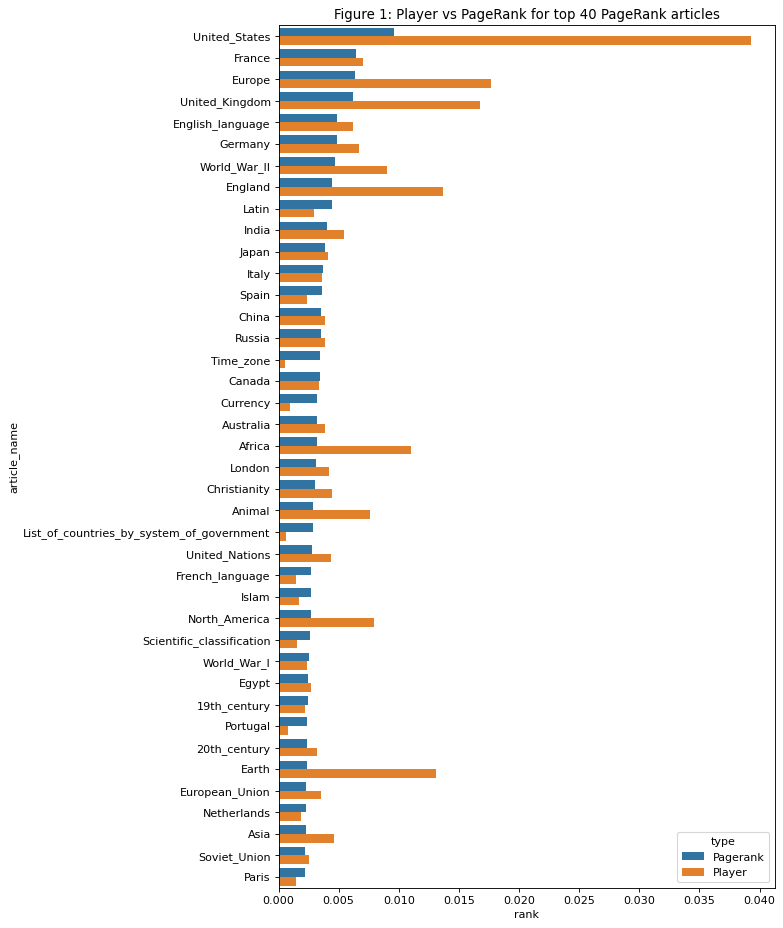

In [7]:
top_player_vs_pagerank_article_frequencies(df_player_frequencies, df_pagerank)

We see that for a lot of articles from Western cultures like `United_States`, `Europe` or `England`, the players rank is higher! However, articles like `Africa` also have a higher player rank. Given that players usually try to reach hubs in their paths to the target article, it is to be expected that general articles like `Africa` still get a higher rank: they are considered by players like "general knowledge hubs" and are often targeted by players. This is an issue: some articles will have a very high rank just because they are considered hubs by players. To make an analysis that is not too sensitive on such articles, we will go coarser grain: we will aggregate articles by country, and compute a rank for each country. the rank for a country $c$ is simply:
$$r_c = \sum_{a \in A_c} r_a$$
where
* $A_c$ is the set of all articles linked to the country $c$

To do that, we associate each article with its country.

In [8]:
article_to_countries = pd.read_csv('data/country_data_full_llama_improved.csv', index_col=0)[['Top_1_name']]
article_to_countries.rename(columns={'Top_1_name': 'country_name'}, inplace=True)
article_to_countries.index.name = 'article_name'
article_to_countries.reset_index(inplace=True)

df_player_frequencies = pd.merge(df_player_frequencies, article_to_countries, on='article_name')
df_pagerank = pd.merge(df_pagerank, article_to_countries, on='article_name')

df_player_frequencies

,article_name,rank,type,country_name
0,United_States,0.039275,Player,united states
1,Europe,0.017631,Player,NaN
2,United_Kingdom,0.016758,Player,united kingdom
3,England,0.013665,Player,NaN
4,Earth,0.013125,Player,NaN
...,...,...,...,...
4595,Lesothosaurus,0.000000,Player,lesotho
4596,Leo_%28constellation%29,0.000000,Player,NaN
4597,Lemon_myrtle,0.000000,Player,australia
4598,Lemon_balm,0.000000,Player,united states


Now that each article is associated to a country, we can draw the same graph, but comparing country aggregates instead of individual articles.

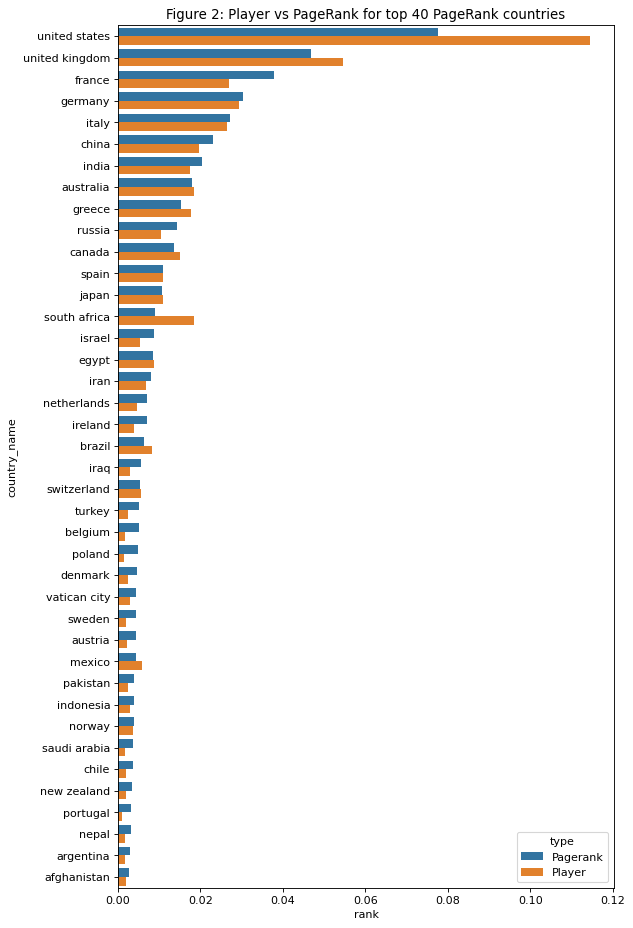

In [9]:
top_player_vs_pagerank_country_frequencies(df_player_frequencies, df_pagerank)

The differences are smaller when we aggregate per country, but again, we still see a bias towards western countries (mostly english speaking countries, actually!).

### Computing rank difference
To investigate further, we will compute the difference between the players rank and the pageranks. Here the difference $d_a$ is defined as:
$$ d_a = r_a - \mathtt{PageRank}_a $$
That way, when it is positive, it means the players tend to go more often to article $a$ than random walk, whereas when it is negative, it means players tend to go less often to article $a$ than random walk.

In [10]:
rank_v_freq_2_columns = pd.merge(df_pagerank[['article_name', 'rank']], df_player_frequencies[['article_name', 'country_name', 'rank']], on='article_name', suffixes=('_pagerank', '_players'), how='right')
rank_v_freq_2_columns = rank_v_freq_2_columns.fillna({'rank_pagerank': 0}) # fill missing pagerank values (those where isolated articles that were not added to the graph, they all have click_count 0 anyway and the pagerank should be 0 too)
rank_v_freq_2_columns['rank_diff'] = rank_v_freq_2_columns['rank_players'] - rank_v_freq_2_columns['rank_pagerank']
rank_v_freq_2_columns.sort_values(by='rank_pagerank', inplace=True, ignore_index=True, ascending=False)
rank_v_freq_2_columns

,article_name,rank_pagerank,country_name,rank_players,rank_diff
0,United_States,0.009567,united states,0.039275,0.029708
1,France,0.006421,france,0.006988,0.000567
2,Europe,0.006340,NaN,0.017631,0.011291
3,United_Kingdom,0.006230,united kingdom,0.016758,0.010528
4,English_language,0.004861,NaN,0.006210,0.001349
...,...,...,...,...,...
4595,Donation,0.000000,united kingdom,0.000000,0.000000
4596,Color_Graphics_Adapter,0.000000,united states,0.000000,0.000000
4597,Schatzki_ring,0.000000,NaN,0.000000,0.000000
4598,Badugi,0.000000,united states,0.000000,0.000000


Again, we aggregate by country.

In [11]:
rank_v_freq_countries = rank_v_freq_2_columns.drop(columns=['article_name']).groupby('country_name', as_index=False, dropna=False).sum()
rank_v_freq_countries.sort_values(by='rank_pagerank', inplace=True, ignore_index=True, ascending=False)
rank_v_freq_countries

,country_name,rank_pagerank,rank_players,rank_diff
0,NaN,0.412083,0.480578,0.068496
1,united states,0.077690,0.114548,0.036858
2,united kingdom,0.046841,0.054451,0.007611
3,france,0.037857,0.026911,-0.010945
4,germany,0.030408,0.029350,-0.001058
...,...,...,...,...
191,cook islands,0.000132,0.000060,-0.000072
192,northern mariana islands,0.000130,0.000035,-0.000095
193,french polynesia,0.000119,0.000041,-0.000078
194,niue,0.000114,0.000000,-0.000114


Let us see how the difference looks like further in the articles list. To do that, we plot the PageRanks and players ranks for all articles, sorted by PageRank. For comparison, we do the same with country aggregates.

Note: here `NaN` represents articles with no linked countries. We see that they make up for about 40% of the PageRank! However those articles are discarded in our analysis since we concentrate on Western cultural biases.

Text(0.5, 0.98, 'Figure 3')

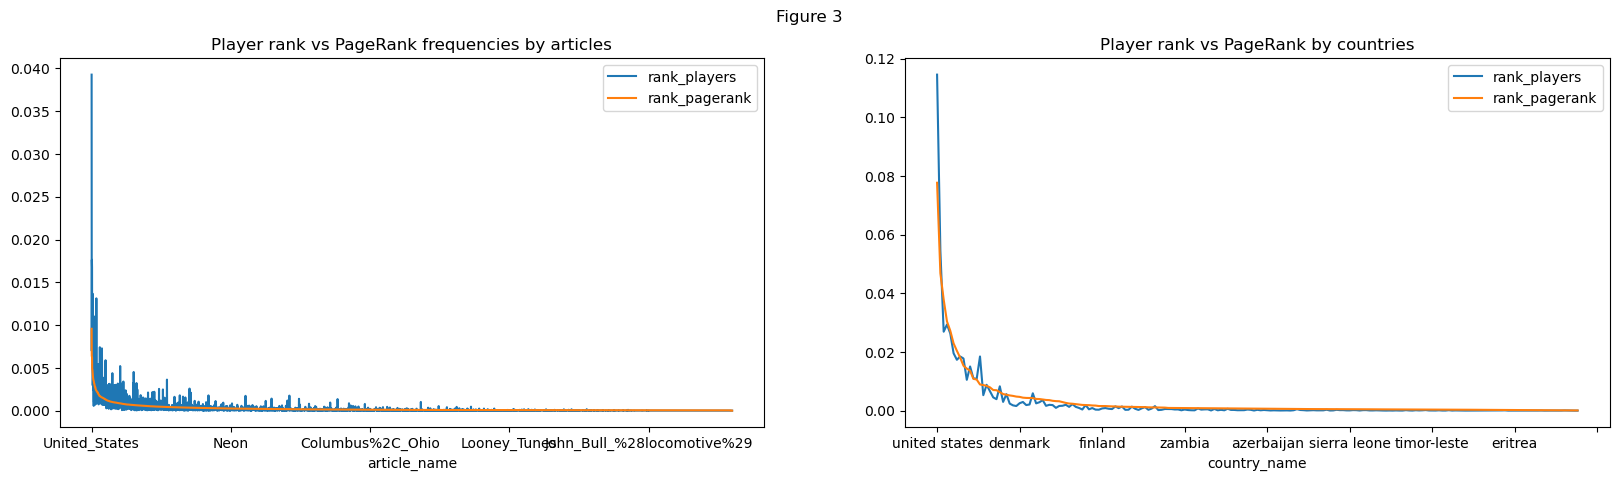

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(20)
ax1.set_title('Player rank vs PageRank frequencies by articles')
rank_v_freq_2_columns.plot(x='article_name', y='rank_players', ax=ax1)
rank_v_freq_2_columns.plot(x='article_name', y='rank_pagerank', ax=ax1)

ax2.set_title('Player rank vs PageRank by countries')
rank_v_freq_countries.dropna().plot(x='country_name', y='rank_players', ax=ax2)
rank_v_freq_countries.dropna().plot(x='country_name', y='rank_pagerank', ax=ax2)
plt.suptitle("Figure 3")

Here we can very clearly see the impact of aggregating by country: it reduces the variance of the difference by summing over all articles from a given country. We will thus focus on analyzing the difference on a country basis as it is a more stable metric. Also, obviously, since we want to detect bias towards certain countries, it makes more sense to aggregate by country.

### High difference countries
Now we will have a look at which countries have the highest difference with respect to PageRank. To do this we sort the differences aggregated by countries from higher to lower values, and then analyze the countries with the highest positive difference (players tend to go more often to them than random walk), and highest negative difference (players tend to go less often to them than random walk)

In [13]:
rank_v_freq_by_diff = rank_v_freq_countries.dropna().sort_values(by='rank_diff', ascending=False)
rank_v_freq_by_diff

,country_name,rank_pagerank,rank_players,rank_diff
1,united states,0.077690,0.114548,0.036858
14,south africa,0.008910,0.018463,0.009552
2,united kingdom,0.046841,0.054451,0.007611
9,greece,0.015315,0.017777,0.002462
20,brazil,0.006301,0.008296,0.001995
...,...,...,...,...
24,belgium,0.005024,0.001797,-0.003227
6,china,0.022924,0.019552,-0.003372
15,israel,0.008719,0.005271,-0.003448
10,russia,0.014331,0.010503,-0.003828


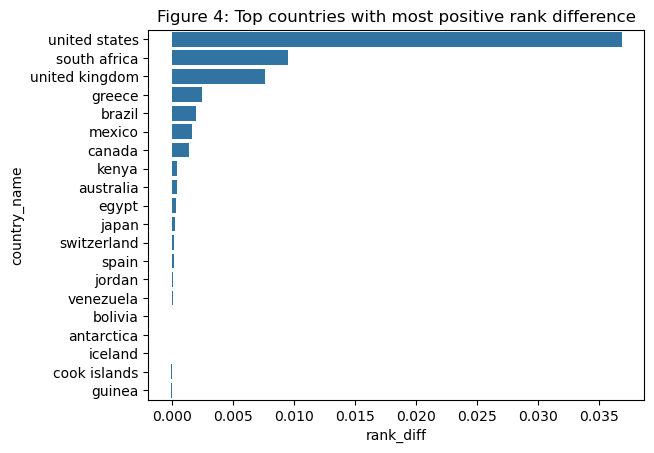

In [14]:
sns.barplot(rank_v_freq_by_diff.head(20), y='country_name', x='rank_diff', orient='y')
plt.title("Figure 4: Top countries with most positive rank difference")
plt.show()

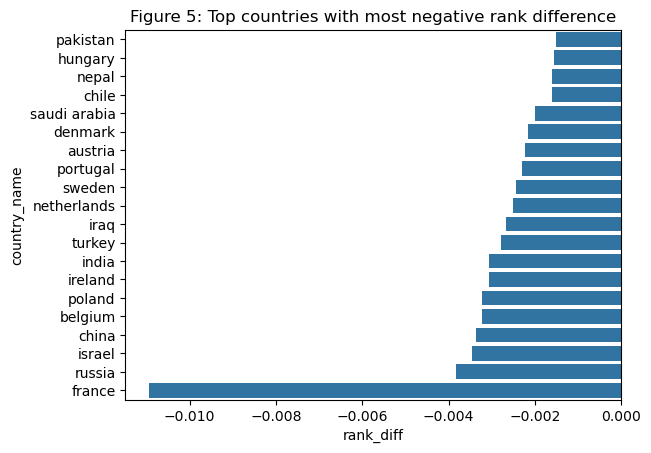

In [15]:
sns.barplot(rank_v_freq_by_diff.tail(20), y='country_name', x='rank_diff', orient='y')
plt.title("Figure 5: Top countries with most negative rank difference")
plt.show()

These results seem to indicate a bias towards english speaking countries: USA and UK have the highest positive difference. Note that this is different from a bias towards Western countries! As we can see, a lot of Western countries have high negative difference, meaning players travel less often to them than random walk (France for example).

### Statistical significance
Lastly, to make sure our conclusions are valid, let us see if the difference in the players behavior is statistically significant. To do that, we compute a chi-square test with the null hypothesis that players rank and PageRank come from the same multinomial distribution. The number of trials (parameter $n$ of the distribution) is set to the total number of clicks in the game.

In [16]:
from scipy.stats import chisquare
# p-value for significance of divergence in distribution
total_number_of_clicks = df_clicks['click_count'].sum()
chisquare(rank_v_freq_countries['rank_players'] * total_number_of_clicks, rank_v_freq_countries['rank_pagerank'] * total_number_of_clicks)

Power_divergenceResult(statistic=36765.44945735122, pvalue=0.0)

Given that the p-value is very close to 0 (floating point has approximated it to 0), we can conclude that the players behave significantly differently than a random walk. Although they are not particularly biased towards all Western countries, they seem to be biased toward english speaking countries.